In [124]:
### Run simulations for sample based imputation


import numpy as np
import sklearn
import pandas as pd
import itertools

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss



Running on google drive

1. Create a shortcut or upload DarthImputer(AutomationProject) to Google Drive
2. Mount drive
3. cd into the directory via magic command

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd /content/drive/MyDrive/DarthImputer(AutomationProject)

/content/drive/.shortcut-targets-by-id/1xI8Y6tPhTyltl7yulQ0vjE-yN5nOgba7/DarthImputer(AutomationProject)


In [125]:
class RandomSelection():

    """
    Query selection method.

    Just selects a random query.

    """

    def __init__(self):
        return

    def select(self, features, labels, missing_data, test_labels):

        return np.random.randint(len(missing_data))

class MeanImpute():

    """
    Imputes each cell with the known mean
    of the column, then selects via
    a query selection method.

    """

    def __init__(self, importance_selector, loss, model = LogisticRegression, error = True):

        self.importance_selector = importance_selector
        self.model = model
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.loss = loss
        self.is_error = error
        return

    def select(self, features, labels, missing_data, test_labels):

        means = np.mean(features, axis = 0)

        missing_data = np.array(missing_data)

        imputed = np.where(np.isnan(missing_data), means, missing_data)
        imputed_norm = self.scaler.fit(imputed).transform(imputed)
        features_norm = self.scaler.fit(features).transform(features)
        model = self.model().fit(features_norm, labels.ravel())

        # Calculate expected model performance
        predicted_probs = model.predict_proba(imputed_norm)

        error = self.loss(test_labels, predicted_probs, imputed_norm)

        assert len(error) == len(missing_data), "error "+ str(len(error)) + " missing " + str(len(missing_data))

        if self.is_error:
            return np.argmin(error)

        return np.argmax(error)



class cross_entropy_loss():

    """
    Helper function for mean impute
    gets loss for each sample after
    imputed

    """

    def __init__(self, classes = [0, 1]):
        self.classes = classes

    def __call__(self, y_true, y_pred, x):
        losses = []
        for i in range(len(y_true)):
            y = y_true[i]
            loss = 0
            for c in range(len(self.classes)):
                loss += -((self.classes[c] == y) * np.log(y_pred[i][c]))
            losses.append(loss)

        return losses

class SampleSubsetAcquisition():

    """
    Like mean imputation, but test all possible
    values for features (or a subset of them)

    """

    def __init__(self, max_subset_size, importance_selector,
    max_ = 1, bins = 3, model = LogisticRegression, error = False,
    all_labels = [0, 1], discrete_values = None, discrete_value_sets = None):

        self.max_subset_size = max_subset_size
        self.importance_selector = importance_selector
        self.model = model
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.max_ = max_
        self.bins = bins
        self.error = error
        self.all_labels = all_labels
        self.discrete_values = discrete_values
        self.discrete_value_sets = discrete_value_sets

        return

    def build_normal_bins(self, features, labels):

        """

        Fills in both discrete and numerical features

        max : the number of standard deviations above and
        below the mean to consider

        bins : number of values to consider between -max and max
        (inclusive)

        Calculate the mean for each feature, given the label.
        if there is only one sample with that label, then
        return just that value.

        """

        if self.discrete_values is None:
            return self.build_only_numerical(features, labels)

        step = self.max_ /  ((self.bins - 1) // 2)

        bins = {label : [] for label in self.all_labels}

        means = {}
        stdvs = {}

        for label in self.all_labels:

            means[label] = np.mean(features[np.where(labels == label)[0]], axis = 0)
            stdvs[label] = np.std(features[np.where(labels == label)[0]], axis = 0)

        for label in self.all_labels:

            for col in range(len(features[0])):

                if self.discrete_values[col]:
                    column = self.discrete_value_sets[col]

                else:
                    if stdvs[label][col] == 0:
                        column = [means[label][col]]
                    else:
                        column = [means[label][col] + stdvs[label][col] * (i + step) for i in range(-self.max_ -1, -self.max_ + self.bins - 1)]

                bins[label].append(column)

            bins[label] = np.array(bins[label], dtype = object)

        return bins

    def build_only_numerical(self, features, labels):

        """
        If no features are discrete, make
        bins using gaussian normal.

        max : the number of standard deviations above and
        below the mean to consider

        bins : number of values to consider between -max and max
        (inclusive)

        Calculate the mean for each feature, given the label.
        if there is only one sample with that label, then
        return just that value.

        """

        bins = {label : [] for label in self.all_labels}

        step = self.max_ /  ((self.bins - 1) // 2)

        means = {}
        stdvs = {}

        for label in self.all_labels:

            means[label] = np.mean(features[np.where(labels == label)[0]], axis = 0)
            stdvs[label] = np.std(features[np.where(labels == label)[0]], axis = 0)

        for label in self.all_labels:

            for col in range(len(features[0])):

                if stdvs[label][col] == 0:
                    column = [means[label][col]]
                else:
                    column = [means[label][col] + stdvs[label][col] * (i + step) for i in range(-self.max_ -1, -self.max_ + self.bins - 1)]

                bins[label].append(column)

            bins[label] = np.array(bins[label], dtype = object)


        return bins

    def repeat_and_fill(self, array, subset):

        """
        given the missing sample,
        make a set of the size of the subset
        and fill in np.nan's with assignments
        of the possible values

        """

        array = np.reshape(array, (1, len(array)))
        array = np.tile(array, (len(subset), 1))

        j = 0
        for col in range(len(array[0])):
            if np.isnan(array[0][col]):
                array[:, col] = subset[:, j]
                j += 1

        return array

    def select(self, features, labels, missing_data, test_labels):

        """
        select class.

        picks the sample with the best score,
        testing a subset of all possible sample
        assignments

        """

        bins = self.build_normal_bins(features, labels)
        normalizer = self.scaler.fit(features)
        features_norm = normalizer.transform(features)
        model = self.model().fit(features_norm, labels.ravel())
        scores = [0 for i in range(len(missing_data))]

        for d in range(len(missing_data)):
            true_label = test_labels[d]
            try:
                label_bin = bins[true_label]
            except TypeError:
                print("true label[0] = ", true_label[0])
                label_bin = bins[true_label[0]]
            possible_values = self.get_possible_values(missing_data[d], label_bin)
            possible_values_norm = normalizer.transform(possible_values)
            pred = model.predict_proba(possible_values_norm)

            scores[d] = self.importance_selector(missing_data[d], pred, true_label, model, possible_values_norm)

        if self.error:
            return np.argmin(scores) # actually error

        return np.argmax(scores)

    def get_possible_values(self, missing_data_point, bins):

        """

        Input: missing_data_point : a sample with some columns as np.nan
               bins : For each np.nan i in missing_data_point, the bins[i]
               has all the possible values it could be


        Output: all the possible permutations of missing_data_point with
                filled in values where the column is np.nan


        """

        # Get subset of possible sample assignments
        subset = self.yield_subset(bins, self.max_subset_size, missing_data_point)

        # Helper function to get the actual subset
        subset = self.repeat_and_fill(missing_data_point, subset)

        return subset

    def yield_subset(self, bins, size, missing_data_point):

        """
        Use itertools iterator to range through all
        possible assignments of a sample.

        stop when the number of samples seen is of a certain
        size

        """

        na_bins = np.where(np.isnan(missing_data_point))

        if len(bins[na_bins]) == 1:
            return np.reshape(bins[na_bins][0], (-1, 1))

        iterator = itertools.product(*bins[na_bins])
        objs = np.zeros((min(size, int(np.prod([len(i) for i in bins[na_bins]]))), len(bins[na_bins])))

        l = 0
        for p in iterator:

            objs[l] = p
            l += 1
            if l >= size:
                del iterator
                return objs

        del iterator
        return objs

class cross_entropy_selector():

    """
    Computes the cross entropy of a set of samples

    require : the class labels (for computing loss)

    """

    def __init__(self, labels = [0, 1]):
        self.labels = labels

    def __call__(self, missing_data, pred, true_label, model, possible_values):
        try:
            return log_loss([true_label[0] for i in range(len(pred))], pred, labels = self.labels)
        except IndexError:
            return log_loss([true_label for i in range(len(pred))], pred, labels = self.labels)


def expected_model_change_logistic(x, y_pred, y_true, model, X):

            # gradient descent update for logistic regression
    # classification accuracy
    # loss = (np.reshape(np.argmax(y_pred, axis = 1), (len(y_pred), 1)) - y_true)

    loss = np.argmax(y_pred, axis = 1) - y_true
    loss = np.reshape(loss, (len(loss), 1))
    # mean partial of each feature
    loss = np.linalg.norm(loss * X, axis = 1)
    # norm of mean gradient
    return np.mean(loss)

def expected_model_change_loss(y_true, y_pred,  X):

        # gradient descent update for logistic regression
    # classification accuracy
    # loss = (np.reshape(np.argmax(y_pred, axis = 1), (len(y_pred), 1)) - y_true)

    loss = np.argmax(y_pred, axis = 1) - y_true
    loss = np.reshape(loss, (len(loss), 1))
    # mean partial of each feature
    loss = np.linalg.norm(loss * X, axis = 1)
    # norm of mean gradient
    return loss

class ImputationSimulation():

    """
    class to run the sample imputation simulation.

    Needs a query selection class (see RandomSelection for an example)

    requires initial features and labels (clean)

    split is another method (should make RandomSplit default) that
    ensures the initial set has at least one of each label. It also
    can start with an arbitrary percent of "clean" data.

    model is an sklearn class. For example, sklearn.linear_model.LogisticRegression
    or RandomForest etc. don't call the model when initializing ImputationSimulation.

    methods is a list of query selection methods. Each method needs a select
    attribute that takes in the missing data, their corresponding labels, and
    the clean data (features and labels). The initialization for the
    methods should be done prior to initializing ImputationSimulation. See
    __main__ for an example using RandomSelection. Also, the select method
    should return an integer, representing the index in the missing data to choose.

    TODO: Implement actual active learning algorithms. As long as it is a
    class with a select method, it should work.

    TODO: Make run_simulation work for batch selection as well. But this might
    be less of a priority (I should have code for the homework to do this).

    """

    def __init__(self, features, labels, split, percent_missing, model,
    methods, evaluation_mode = "all", fold = None, all_labels = [0, 1]):
        self.features = features
        self.labels = labels
        self.percent_missing = percent_missing
        self.model = model
        self.methods = methods
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.split = split
        self.evaluation_mode = evaluation_mode
        self.all_labels = all_labels

        if self.evaluation_mode == "cross validation":
            if fold is None:
                self.fold = 3
            else:
                self.fold = fold

        return

    def add_and_remove(self, feat, label, feat_full, label_full,
    unlabel, test_labels, x, indexes):

        """
        Helper function to deal with adding samples
        from the unlabeled set to the labeled set.

        L: the set of intances with labels
        U: the set of instances without labels

        Input: feat: the current set of features in L
               label: the current set of labels in L
               feat_full: all the available features
               label_full: every label (these are unknown in practice)
               unlabel: the current set of features in U (missing features)
               x: the index to remove from unlabel
               indexes: index list such that index[x] is the index of the
                        point in the feat_full and label_full objects

        Output: feat with a single sample added
                label with a single sample added
                unlabel with a single sample removed
                indexes with a single index removed

        """

        feat_shape = feat.shape[1]

        unlabel = np.delete(unlabel, x, axis = 0)
        test_labels = np.delete(test_labels, x, axis = 0)

        label_to_get = np.array(indexes)[x]
        indexes = np.delete(indexes, x)

        label_to_add = label_full[label_to_get]
        feature_to_add = feat_full[label_to_get]

        if len(label_to_add.shape) == 0:
            label_to_add = np.reshape(label_to_add, (1, 1))[0]
            feature_to_add = np.reshape(feature_to_add, (1, feat_shape))
            label = np.append(label, label_to_add, axis = 0)
            feat = np.append(feat, feature_to_add, axis = 0)
        else:
            label = np.append(label, label_to_add)
            feat = np.vstack((feat, feature_to_add))

        return feat, label, unlabel, test_labels, indexes

    def randomly_na(self, data, percent_missing):

        """
        For each cell in the data, choose if
        it should be nan with some
        probability given by percent_missing.

        Require that percent_missing is in the domain [0, 1].
        if percent_missing is 0.2, for example, then there's a
        20% chance a given cell will be turned to np.nan

        """

        if percent_missing > 1:
            percent_missing = percent_missing / 100

        mask = np.random.rand(data.shape[0], data.shape[1])
        mask = mask < percent_missing
        data = (np.where(mask, np.nan, data))

        return data

    def evaluate(self, features_imputed, labels_imputed, model, features_norm, means, stdvs):

        """

        "all" method uses the current model to
        get the accuracy for the entire dataset

        "cross validation" does the cross val
        on only the current clean data (doesn't need
        to "cheat" by knowing the features of the missing
        data pool)

        """

        if self.evaluation_mode == "all":
            accuracy = self.accuracy_on_all_samples(self.features,
             self.labels, features_imputed, labels_imputed, model)
            means.append(accuracy)

        if self.evaluation_mode == "cross validation":
            scores = self.cross_validation(features_norm, labels_imputed.ravel(), model)

            if np.isnan(np.mean(scores)):
                scores = self.accuracy_on_all_samples(self.features,
                 self.labels, features_imputed, labels_imputed, model)

            means.append(np.mean(scores))
            stdvs.append(np.std(scores))


        return means, stdvs




    def run_simulation(self):

        """
        Ranges through each query selection method
        and returns the means and stdvs of each

        all simulations should start with the same data
        and use the same evaluation metric

        """

        # Make initial set with no missing data
        n = len(self.features)
        initial_set_indexes, missing_data_indexes = self.split(self.features, self.labels)

        # Initial_set_indexes : has all the indexes for the set with no missing data
        # missing_data_indexes : initial indexes for the data with missing values.
                                #also the indexes for the corresponding labels

        # split the data into the initial set and missing data set
        features_imputed = self.features[initial_set_indexes]
        labels_imputed = self.labels[initial_set_indexes]

        # create the missing data set. Should start the same for all simulations
        missing_features_all = self.randomly_na(self.features, self.percent_missing)

        missing_features = missing_features_all[missing_data_indexes]
        test_labels = self.labels[missing_data_indexes]

        # mean and standard deviation of accuracy for each selection method
        # in self.methods. note that stdvs will only be used when cross validation
        # evaluation method is used.
        all_means = []
        all_stdvs = []

        # Run simulation with the same initial set for many
        # possible imputation query selection methods
        for selection_method in self.methods: # each selection_method is an object

            # indexes corresponding to data currently with missing values
            # maps each index in missing_features to the full dataset (self.features)
            indexes = missing_data_indexes.copy()
            missing_features = missing_features_all[missing_data_indexes]
            test_labels = self.labels[missing_data_indexes]
            features_imputed = self.features[initial_set_indexes]
            labels_imputed = self.labels[initial_set_indexes]

            print("RUNNING SIMULATION")
            print(selection_method)

            means = []
            stdvs = []

            while len(labels_imputed) < n: # Stop at n, since there will be no disagreement on the last sample

                # mean center data everytime we fir a model
                features_norm = self.scaler.fit(features_imputed).transform(features_imputed)
                # Train model on current set of imputed (clean) data
                model = self.model().fit(features_norm, labels_imputed.ravel())

                # Get accuracy metrics for current clean data
                means, stdvs = self.evaluate(features_imputed, labels_imputed, model, features_norm, means, stdvs)

                # Call the oracle to select the next features to impute
                x = selection_method.select(features_imputed, labels_imputed,
                 missing_features, test_labels)

                # Add x to labeled_set, remove from unlabeled
                features_imputed, labels_imputed, missing_features, test_labels, indexes = self.add_and_remove(features_imputed,
                                                                                   labels_imputed,
                                                                                   self.features,
                                                                                   self.labels,
                                                                                   missing_features,
                                                                                   test_labels,
                                                                                   x,
                                                                                   indexes)

            # Add current run accracies to set of all simulations
            all_means.append(means)
            all_stdvs.append(stdvs)

        return all_means, all_stdvs

    def cross_validation(self, features, labels, model):

        """
        Split the dataset into train and test, compute the self.fold times cross validation.

        """

        scores = cross_val_score(model, features, labels, cv = self.fold)

        return scores

    def calc_loss(self, features_imputed_norm, labels_imputed, model):

        """
        Returns training accuracy of the classifier

        """

        model_ = model.fit(features_imputed_norm, labels_imputed)
        pred = model_.predict(features_imputed_norm)
        return np.sum(pred == labels_imputed) / len(pred)


    def accuracy_on_all_samples(self, missing_features_imputed,
    test_labels, known_features, train_labels, model):

        """
        Calculates the accuracy of the
        current trained model on all unseen (missing values)
        samples (cheat a bit by looking at actual values,
        should be used for evaluation only, not query
        selection)

        """
        known_features_norm = self.scaler.fit(known_features).transform(known_features)
        missing_features_imputed_norm = self.scaler.fit(missing_features_imputed).transform(missing_features_imputed)
        pred = model.predict(missing_features_imputed_norm)

        return np.sum(pred == test_labels) / len(pred)


class RandomSplit():

    """
    splits data by split_percent into
    clean and missing data.

    Get a random subset, but restart if
    not all labels present (needed for sklearn)

    """

    def __init__(self, split_percent):
        self.split = split_percent

    def __call__(self, features, labels):
        all_ind = [i for i in range(len(features))]
        n = len(all_ind)

        indexes_samples_labeled = np.random.choice(all_ind, size = n, replace = False)

        # Keep track of indexes in unlabeled data so we add the correct points
        label_set_indexes = indexes_samples_labeled[0 : int(self.split * n)]
        indexes = indexes_samples_labeled[int(self.split * n) : n]

        for label in np.unique(labels):
            if np.sum(labels[label_set_indexes] == label) == 0:
                return self.__call__(features, labels)

        return label_set_indexes, indexes

def str_to_int_labels(labels):

    """
    turns all labels that are strings
    into an integer starting at 0

    """

    strs = np.unique(labels)

    for i in range(len(strs)):
        labels = np.where(labels == strs[i], i, labels)

    return labels.astype(np.int32)


class SamplingBasedSampleAcquisition():

    """
    Sample possible features from a Gaussian

    if the feature is discrete, sample
    uniformly from all possible

    """

    def __init__(self, sample_size, importance_selector,
    model = LogisticRegression, error = False, discrete_values = None,
    discrete_value_sets = None):

        self.sample_size = sample_size # N
        self.importance_selector = importance_selector
        self.model = model
        self.scaler = sklearn.preprocessing.StandardScaler()
        self.error = error
        self.discrete_values = discrete_values
        self.discrete_value_sets = discrete_value_sets

        return

    def sample_N_times(self, array, means, stdvs):

        """
        Sample from gaussian (numerical) or
        uniform (discrete) N times

        """

        if self.discrete_values is None:

            return self.sample_only_normal(array, means, stdvs)

        array = np.reshape(array, (1, len(array)))
        array = np.tile(array, (self.sample_size, 1))


        for col in range(len(array[0])):

            if np.isnan(array[0][col]):

                if self.discrete_values[col]:
                    column = np.random.choice(self.discrete_value_sets[col],
                    size = self.sample_size, replace = True)

                else:
                    column = np.random.normal(means[col], stdvs[col], size = self.sample_size)

                array[:, col] = column

        return array

    def sample_only_normal(self, array, means, stdvs):

        """
        Used when all features discrete.
        Fill in all missing values with
        Gaussian random variable

        """

        array = np.reshape(array, (1, len(array)))
        array = np.tile(array, (self.sample_size, 1))

        for col in range(len(array[0])):

            if np.isnan(array[0][col]):

                array[:, col] = np.random.normal(means[col], stdvs[col], size = self.sample_size)

        return array

    def select(self, features, labels, missing_data, test_labels):


        """
        select method.
        For each instance, fill in
        each missing value with a Gaussian random (numerical feature)
        or a uniform random (discrete). Get N samples for each instance.
        Then, compute score (average score) across all samples.
        Pick instance with best average score.

        """

        means = np.mean(features, axis = 0)
        stdvs = np.std(features, axis = 0)
        normalizer = self.scaler.fit(features)
        features_norm = normalizer.transform(features)
        model = self.model().fit(features_norm, labels.ravel())
        scores = [0 for i in range(len(missing_data))]

        for d in range(len(missing_data)):
            true_label = test_labels[d]
            possible_values = self.sample_N_times(missing_data[d], means, stdvs)
            possible_values_norm = normalizer.transform(possible_values)
            pred = model.predict_proba(possible_values_norm)
            scores[d] = self.importance_selector(missing_data[d], pred, true_label, model, possible_values_norm)

        if self.error:
            return np.argmin(scores) # actually error

        return np.argmax(scores)

In [18]:
data = pd.read_csv("fertility_Diagnosis.txt")
matrix = np.array(data)
labels = matrix[:, -1]
features = matrix[:, 0:9]
features = np.array(features, dtype = np.float64)
labels = str_to_int_labels(labels)
split = RandomSplit(split_percent = 0.1)
model = LogisticRegression


methods = [RandomSelection(),

           MeanImpute(importance_selector = cross_entropy_selector(),
                      loss = cross_entropy_loss()),

           SampleSubsetAcquisition(max_subset_size = 100,
                                   importance_selector = cross_entropy_selector(),
                                   max_ = 10,
                                   bins = 3,
                                   model = model,
                                   error = True),


           SamplingBasedSampleAcquisition(sample_size = 10,
                                           importance_selector = cross_entropy_selector(),
                                           error = True)


           ]

impute = ImputationSimulation(features, labels, split, 0.4, model, methods, "cross validation")


In [126]:
means, stds = impute.run_simulation()

Text(0.5, 1.0, 'Sample Based Active Imputation')

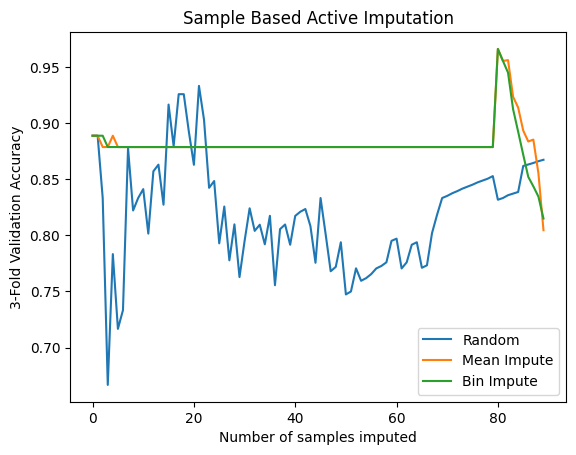

In [20]:
plt.plot(means[0])
plt.plot(means[1])
plt.plot(means[2])

plt.legend(["Random", "Mean Impute", "Bin Impute"])
plt.xlabel("Number of samples imputed")
plt.ylabel("3-Fold Validation Accuracy")
plt.title("Sample Based Active Imputation")

Text(0.5, 1.0, 'Sample Based Active Imputation')

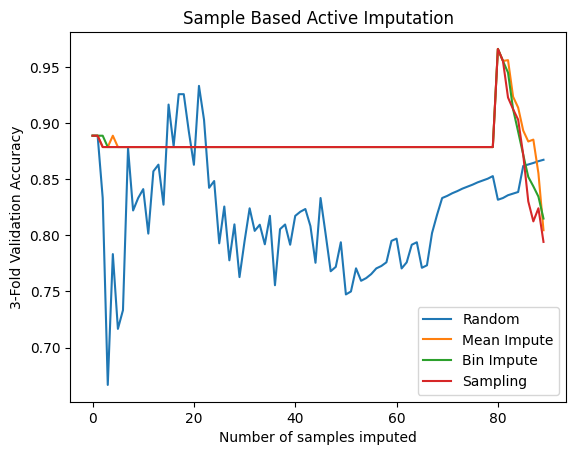

In [21]:
plt.plot(means[0])
plt.plot(means[1])
plt.plot(means[2])
plt.plot(means[3])

plt.legend(["Random", "Mean Impute", "Bin Impute", "Sampling"])
plt.xlabel("Number of samples imputed")
plt.ylabel("3-Fold Validation Accuracy")
plt.title("Sample Based Active Imputation")

In [22]:
def PrintAllSimulations(all_means, all_stdvs):

    means = np.mean(np.array(all_means), axis = 0)
    stdvs = np.mean(np.array(all_stdvs), axis = 0)

    colors = ["blue", "red", "green", "orange", "purple", "yellow", "black"]

    print(means.shape)

    for i in range(len(means)):
        print(plt.plot(means[i], color = colors[i]))

    x = [i for i in range(0, len(means[0]))]
    std_plot = [stds[i] for i in range(0, len(stds))]
    y = [means[i] for i in range(0, len(means))]

    for i in range(len(means)):
        print(plt.errorbar(x, means[i], yerr = stdvs[i], alpha = 0.3, color = colors[i]))





Run for 10 Seeds

In [127]:
all_means = []
all_stdvs = []

for seed in range(10):
    np.random.seed(seed)
    means, stdvs = impute.run_simulation()
    all_means.append(means)
    all_stdvs.append(stdvs)

(4, 90)
<ErrorbarContainer object of 3 artists>
<ErrorbarContainer object of 3 artists>
<ErrorbarContainer object of 3 artists>
<ErrorbarContainer object of 3 artists>


Text(0.5, 1.0, 'Sample Based Active Imputation by Expected Cross Entropy Loss')

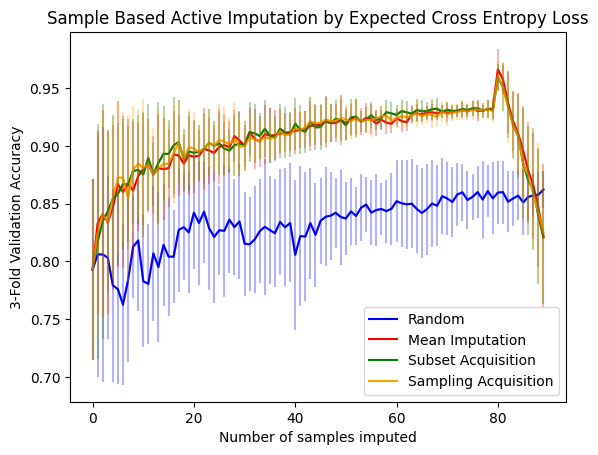

In [24]:
PrintAllSimulations(all_means, all_stdvs)
plt.legend(["Random", "Mean Imputation", "Subset Acquisition", "Sampling Acquisition"], loc = "lower right")
plt.xlabel("Number of samples imputed")
plt.ylabel("3-Fold Validation Accuracy")
plt.title("Sample Based Active Imputation by Expected Cross Entropy Loss")

Expected Model Change

In [128]:
matrix = np.array(data)
labels = matrix[:, -1]
features = matrix[:, 0:9]
features = np.array(features, dtype = np.float64)
labels = str_to_int_labels(labels)
split = RandomSplit(split_percent = 0.1)
model = LogisticRegression


mean1 =  MeanImpute(importance_selector = expected_model_change_logistic,
                      loss = expected_model_change_loss, error = False)
mean2 = MeanImpute(importance_selector = cross_entropy_selector(),
                      loss = cross_entropy_loss(), error = True)


methods_expected_change = [RandomSelection(),

           mean1,

             mean2,


           ]

impute_expected = ImputationSimulation(features, labels, split, 0.4, model, methods_expected_change, "cross validation")


In [115]:
all_means_expected = []
all_stdvs_expected = []

for seed in range(10):
    np.random.seed(seed)
    means, stdvs = impute_expected.run_simulation()
    all_means_expected.append(means)
    all_stdvs_expected.append(stdvs)

(3, 90)
<ErrorbarContainer object of 3 artists>
<ErrorbarContainer object of 3 artists>
<ErrorbarContainer object of 3 artists>


Text(0.5, 1.0, 'Comparison of Different Scoring Methods')

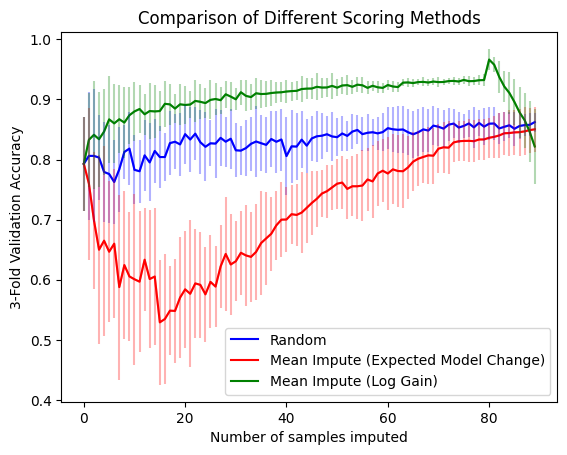

In [114]:
PrintAllSimulations(all_means_expected, all_stdvs_expected)
plt.legend(["Random", "Mean Impute (Expected Model Change)", "Mean Impute (Log Gain)"], loc = "lower right")
plt.xlabel("Number of samples imputed")
plt.ylabel("3-Fold Validation Accuracy")
plt.title("Comparison of Different Scoring Methods")

Handling discrete data

1. make discrete_values -> list mapping each feature to boolean. True if discrete
2. for each feature that is discrete, make a list with all the possible values at that position. Can use np.unique to do this.

In [34]:
matrix = np.array(data)
labels = matrix[:, -1]
features = matrix[:, 0:9]
features = np.array(features, dtype = np.float64)
labels = str_to_int_labels(labels)
split = RandomSplit(split_percent = 0.1)
model = LogisticRegression
discrete_values = [False, False, True, True, True, False, False, False, False]
discrete_value_sets = [[], [], [0, 1], [0, 1], [0, 1], [], [], [], []]


methods = [RandomSelection(),


           SampleSubsetAcquisition(max_subset_size = 100,
                                   importance_selector = cross_entropy_selector(),
                                   max_ = 10,
                                   bins = 3,
                                   model = model,
                                   error = True,
                                  discrete_values = discrete_values,
                                  discrete_value_sets = discrete_value_sets)



           ]

impute_new = ImputationSimulation(features, labels, split, 0.4, model, methods, "cross validation")


In [35]:
all_means_new = []
all_stdvs_new = []

for seed in range(10):
    np.random.seed(seed)
    means, stdvs = impute_new.run_simulation()
    all_means_new.append(means)
    all_stdvs_new.append(stdvs)

RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
Valu

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
Valu

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
Valu

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
Valu

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
Valu

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
Valu

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
Valu

RUNNING SIMULATION


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
1 fits failed out of a total of 3.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1241, in fit
    raise ValueError(
Valu

(2, 90)
<ErrorbarContainer object of 3 artists>
<ErrorbarContainer object of 3 artists>


Text(0.5, 1.0, 'Sample Based Feature Value Acquisition')

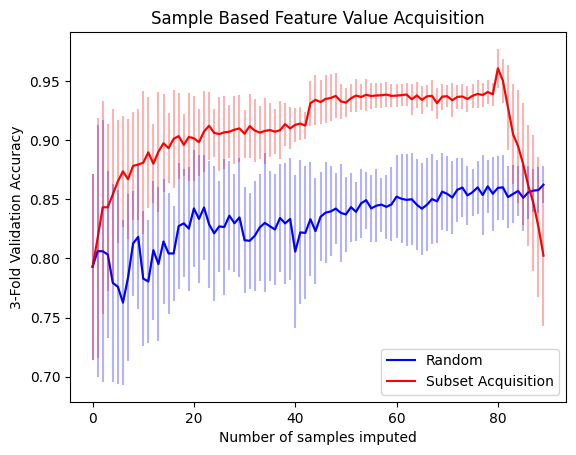

In [36]:
PrintAllSimulations(all_means_new, all_stdvs_new)
plt.legend(["Random", "Subset Acquisition"], loc = "lower right")
plt.xlabel("Number of samples imputed")
plt.ylabel("3-Fold Validation Accuracy")
plt.title("Sample Based Feature Value Acquisition")

Running On Second Dataset

In [37]:
data2 = pd.read_csv("NPHA-doctor-visits.csv")
matrix2 = np.array(data2)
labels2 = matrix2[:, 0]
features2 = matrix2[:, 1:]

Every feature is discrete here. So just use np.unique to make all of them be sampled that way.

In [38]:
discrete_values = [True for i in range(len(features2[0]))]
discrete_value_sets = [np.unique(features2[:, i]) for i in range(len(features2[0]))]

split = RandomSplit(split_percent = 0.1)
model = LogisticRegression

loss = cross_entropy_loss([1,2,3])

methods = [RandomSelection(),

           MeanImpute(importance_selector = cross_entropy_selector(labels = [1,2,3]),
                      loss = loss),

           SampleSubsetAcquisition(max_subset_size = 20,
                                   importance_selector = cross_entropy_selector(labels = [1,2,3]),
                                   max_ = 1,
                                   bins = 3,
                                   model = model,
                                   error = True,
                                  discrete_values = discrete_values,
                                  discrete_value_sets = discrete_value_sets,
                                  all_labels = [1,2,3]),


           SamplingBasedSampleAcquisition(sample_size = 10,
                                           importance_selector = cross_entropy_selector(labels = [1,2,3]),
                                           error = True)


           ]

impute_doctor_visits = ImputationSimulation(features2, labels2, split, 0.4, model, methods, "cross validation")


In [39]:
means2, stdvs2 = impute_doctor_visits.run_simulation()

RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION


Text(0, 0.5, '3-Fold Validation Accuracy')

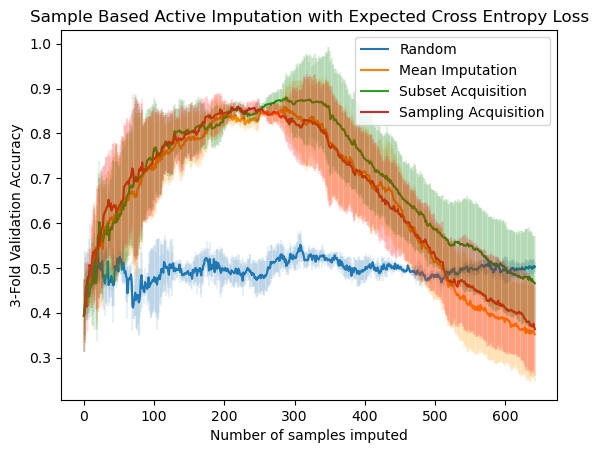

In [ ]:
plt.plot(means2[0])
plt.plot(means2[1])
plt.plot(means2[2])
plt.plot(means2[3])
x_vals = [i for i in range(len(means2[0]))]
plt.errorbar(x = x_vals, y = means2[0], yerr = stdvs2[0], alpha = 0.1, color = "tab:blue")
plt.errorbar(x = x_vals, y = means2[1], yerr = stdvs2[1], alpha = 0.1, color = "orange")
plt.errorbar(x = x_vals, y = means2[2], yerr = stdvs2[1], alpha = 0.1, color = "green")
plt.errorbar(x = x_vals, y = means2[3], yerr = stdvs2[1], alpha = 0.1, color = "red")
plt.legend(["Random", "Mean Imputation", "Subset Acquisition", "Sampling Acquisition"], loc = "upper right")
plt.title("Sample Based Active Imputation with Expected Cross Entropy Loss")
plt.xlabel("Number of samples imputed")
plt.ylabel("3-Fold Validation Accuracy")

In [120]:
discrete_values = [True for i in range(len(features2[0]))]
discrete_value_sets = [np.unique(features2[:, i]) for i in range(len(features2[0]))]

split = RandomSplit(split_percent = 0.1)
model = LogisticRegression

loss = cross_entropy_loss([1,2,3])

mean1 =  MeanImpute(importance_selector = expected_model_change_logistic,
                      loss = expected_model_change_loss, error = False)
mean2 = MeanImpute(importance_selector = cross_entropy_selector(),
                      loss = cross_entropy_loss(), error = True)

methods = [RandomSelection(),


           mean1,
           mean2


           ]

impute_doctor_visits = ImputationSimulation(features2, labels2, split, 0.4, model, methods, "cross validation")


In [121]:
all_means_new = []
all_stdvs_new = []

for seed in range(3):
    np.random.seed(seed)
    means, stdvs = impute_doctor_visits.run_simulation()
    all_means_new.append(means)
    all_stdvs_new.append(stdvs)

RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION
RUNNING SIMULATION


(3, 643)
<ErrorbarContainer object of 3 artists>
<ErrorbarContainer object of 3 artists>
<ErrorbarContainer object of 3 artists>


Text(0.5, 1.0, 'Comparison of Different Scoring Methods')

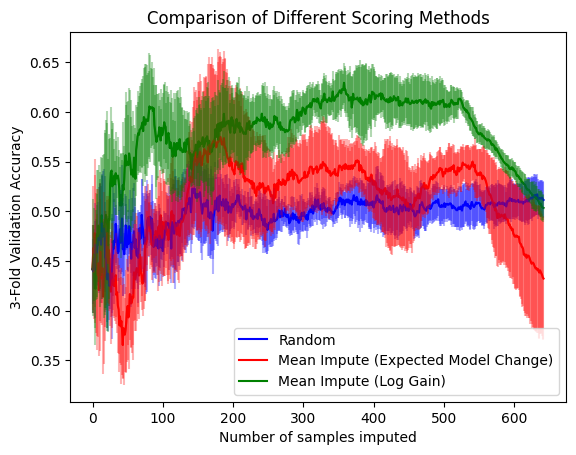

In [122]:
PrintAllSimulations(all_means_new, all_stdvs_new)
plt.legend(["Random", "Mean Impute (Expected Model Change)", "Mean Impute (Log Gain)"], loc = "lower right")
plt.xlabel("Number of samples imputed")
plt.ylabel("3-Fold Validation Accuracy")
plt.title("Comparison of Different Scoring Methods")